<a href="https://colab.research.google.com/github/Deepak-Sathyanarayanan/twitter_sentiment_analysis/blob/master/02_preprocessingAndModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Mounting Drive to this notebook**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Importing the required Libraries**

In [2]:
# pandas
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# ssl
import ssl

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# re
import re

# word cloud
from wordcloud import WordCloud

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Word2vec
import gensim

# numpy
import numpy as np

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# iitertools
import itertools

#### **Pre Processing**

##### **Reading the dataset**

In [3]:
path = '/content/gdrive/My Drive/Colab Notebooks/Sentiment_Analysis_Capstone_3/sentiment140_train.csv'
data = pd.read_csv(path, encoding ="ISO-8859-1" , names=['sentiment', 'id', 'date', 'query', 'user_id', 'text'])

In [4]:
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)

##### **Mapping Labels to corresponding numberic classification**

In [5]:
decode_mapping = {0: "Negative", 4: "Positive"}

def decode_sentiment(x):
    return decode_mapping[int(x)]

data['sentiment'] = data['sentiment'].apply(lambda x: decode_sentiment(x))

##### **Visualization of the labels**

Text(0.5, 1.0, 'Sentiment Data Distribution')

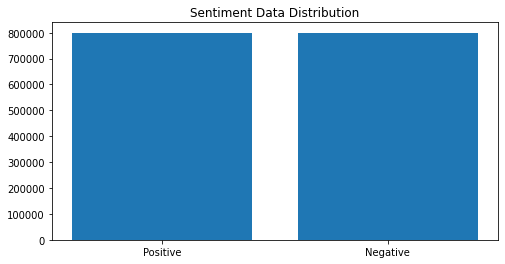

In [6]:
val_count = data['sentiment'].value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

##### **Download Stopwords**

In [7]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

###### What are stop words?

>Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...

###### What is Stemming?
> Stemming approximates a word to its root i.e identifying the original word by removing the plurals or the verb forms. For example, ‘rides’ and ‘riding’ both denote ‘ride’. So, if a sentence contains more than one form of ride, then all those will be marked to be identified as the same word.


###### What is Lemmentization?
> Lemmatization analyzes the structure of words, the relationship between words and parts of words to accurately identify the root word. Part of speech tagger and vocabulary words helps to return the dictionary form of a word. But this requires a lot of processing time and disk space. The root word is known as a lemma.

###### What does <u>*@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+*</u> mean?

<ul type= "disc">
  <li> @ matches "@" </li>
  <li> The \S+ matches anything that is NOT matched by \s where \s matches a whitespace </li>
  <li> + one or more recurrance </li>
  <li> | represents the OR operator </li>
  <li> https?:\S+ represents https links in tweets followed by a single colon. Followed by \S+, one or more non-whitespaces  </li>
  <li>  http?:\S similarly for http </li>
  <li> ? represent a single occurance of character  </li>
  <li> ^ represents negation  </li>
  <li> [^A-Za-z0-9]+ represents any anything apart from A-Z, a-z, 0-9  </li>

  [Source](https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html#zz-1.11)

In [8]:
stop = stopwords.words('english')

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:             # if the text is not in stop words bag (i.e) valid words
      if stem:                              # Default = FALSE 
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
data.text = data.text.apply(lambda x: preprocess(x))

##### **Word Clouds**

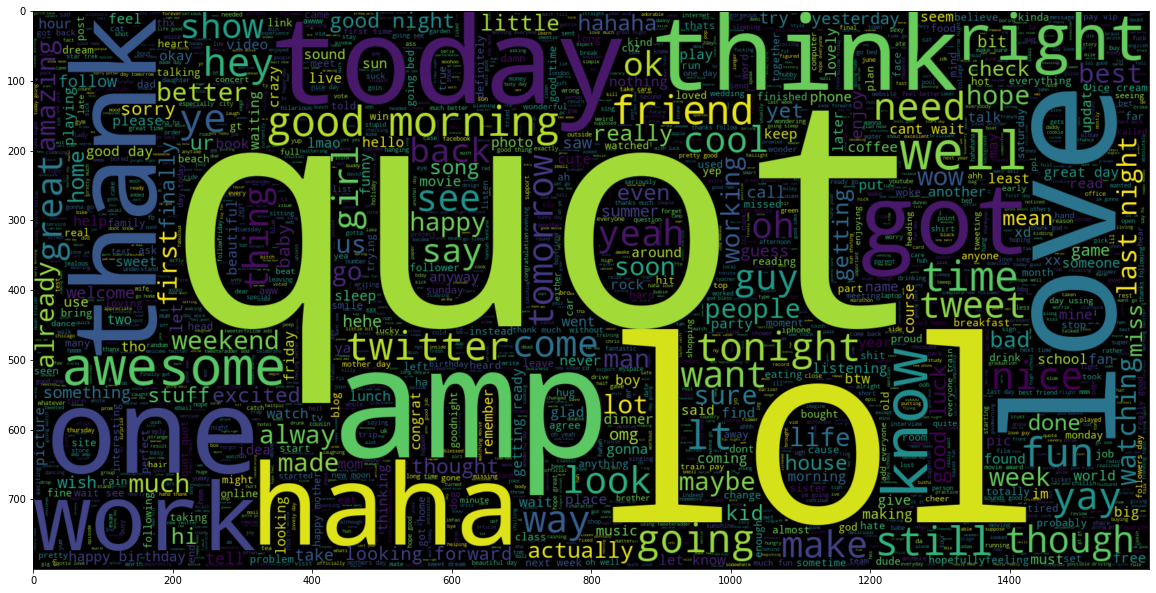

In [11]:
#word cloud - Positive

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(data[data['sentiment'] == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

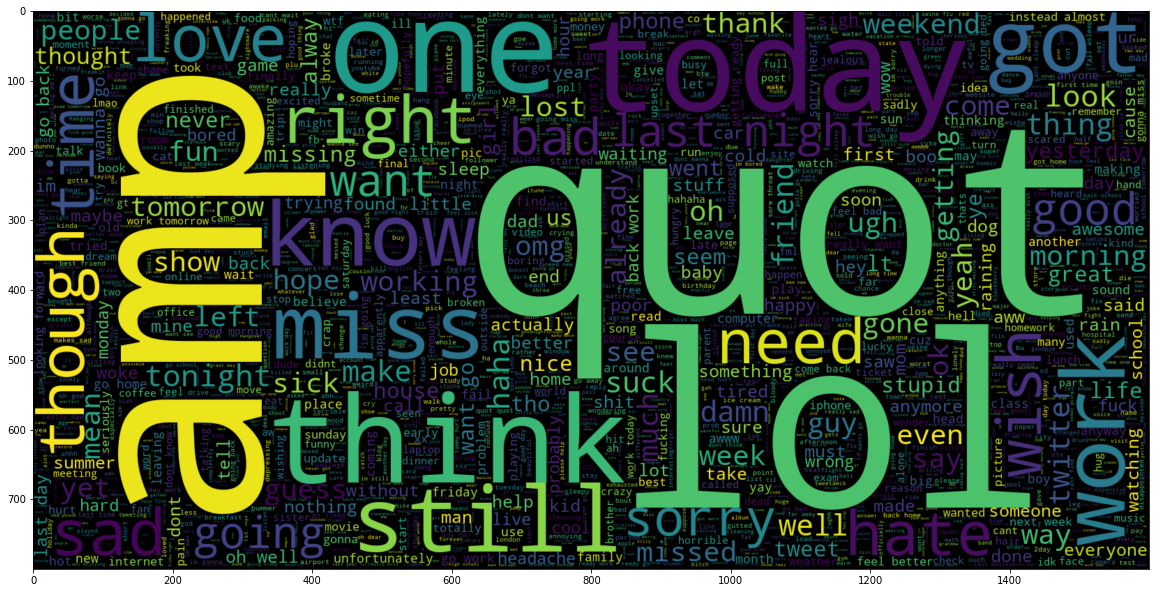

In [12]:
#word cloud - Negative

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data['sentiment'] == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [13]:
TRAIN_SIZE = 0.8
# MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

# Where is Max_Sequence MAX_SEQUENCE_LENGTH = 30 used?
#   --> Pad Sequencing 
#   --> In embedding layer
#   --> In Neural Netwoek input shape

#### **Train Test Split**

In [14]:
train_data, test_data = train_test_split(data, test_size=1-TRAIN_SIZE,random_state=7)     # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [15]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


#### **Tokenization**
> Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


#### **Shape of Train & Test Data (Before Padding)**

In [17]:
print("train_data shape:",train_data.shape)
print("test_data shape:",test_data.shape)

train_data shape: (1280000, 2)
test_data shape: (320000, 2)


#### **Pad_Sequence**

> As we are going to build a sequence model, We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [18]:
%%time
MAX_SEQUENCE_LENGTH = 30

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_SEQUENCE_LENGTH)

CPU times: user 25.5 s, sys: 91.9 ms, total: 25.5 s
Wall time: 25.6 s


#### **Shape of Train & Test Data (After Padding)**

In [19]:
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


#### **Label Encoder**

In [20]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000,)
y_test shape: (320000,)



#### **Reshaping y_train & y_test in order to feed to neural networks**

In [21]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


#### **Word Embedding**
> Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

> Basically, it's a <u>feature vector representation of words</u> which are used for other natural language processing applications.

> We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model. The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification

##### **Download pretrained glove model - word embedding**

In [22]:
%%time
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-11-04 04:26:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-04 04:26:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-04 04:26:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [23]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10


# Where is (EMBEDDING_DIM) EMBEDDING_DIM = 300 used?
#   --> In embedding layer
#   --> In embedding matrix


# Where is BATCH_SIZE used?
#   --> while fitting NN ==> 1024
#   --> while predicting labels ==> 10000


# Where is LR = 1e-3 used?
#   --> while compiling the model


# Where is EPOCHS = 10 used?
#   --> while fitting NN

##### **Extracting the words and their coefficients in glove model and store it to a variable called <u>embeddings_index</u>**

In [24]:
%%time

GLOVE_EMB = '/content/glove.6B.300d.txt'


embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.
CPU times: user 27.3 s, sys: 807 ms, total: 28.1 s
Wall time: 28.1 s


In [25]:
print("values:", values)
print("word:", word)  
print("coeff:",coefs)
print("========")

values: ['sandberger', '0.429191', '-0.296897', '0.15011', '0.245201', '-0.00352027', '-0.0576971', '0.1409', '-0.222294', '0.221153', '0.767218', '-0.0772662', '-0.0710635', '0.0629486', '-0.220179', '-0.108197', '-0.301419', '0.232164', '0.168669', '-0.00452476', '0.168254', '-0.0579106', '-0.0362662', '-0.273464', '-0.162976', '0.239398', '-0.0119058', '0.044685', '0.105252', '0.102867', '-0.0232984', '-0.0114432', '-0.381673', '0.06122', '0.0170547', '0.415463', '-0.109101', '0.0959916', '0.19149', '-0.00752907', '-0.194603', '-0.0431976', '0.259788', '0.00527856', '-0.183626', '0.225188', '-0.0187726', '-0.158172', '-0.586937', '0.249259', '-0.130252', '-0.0537497', '0.0315535', '-0.18562', '0.0610198', '-0.0850566', '-0.0965162', '0.278621', '-0.247254', '-0.153895', '0.0418453', '0.0704212', '-0.062286', '-0.284913', '0.0152124', '0.144002', '0.335902', '-0.288315', '-0.00253548', '-0.0876423', '-0.0574409', '0.00670068', '-0.0753335', '-0.0677815', '-0.056624', '0.19296', '0.02

In [26]:
for k,v in embeddings_index.items():
  print(k,v)
  break

the [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-0

##### **Using the embedding index from glove model, create a embedding matrix for the document**

In [27]:
# vocab_size = 290575  (rows)     ----> Extracted by tokenizing the document and finding its length
# EMBEDDING_DIM = 300  (columns)  ----> hardcoded length
# word_index                      ----> Tokenized words
# embedding_matrix                ----> The matrix which we got from glove model (Coefficients)


embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13602   , -0.11594   , -0.017078  , ..., -0.33759999,
         0.070098  ,  0.24642   ],
       [-0.24501   , -0.12491   , -0.2536    , ..., -0.41073   ,
        -0.61926001,  0.0039007 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

#### **Creating Embedding layer**
> Embedding matrix serve as weights to embedding layer

In [29]:
# MAX_SEQUENCE_LENGTH = 30
# vocab_size = 290575

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#### **Neural Network Layers**


1.   [**SpatialDropout1D**](https://keras.io/api/layers/regularization_layers/spatial_dropout1d/) - Spatial 1D version of Dropout. This version performs the same function as Dropout**, however, it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead.

2.   [**Conv1D**](https://keras.io/api/layers/convolution_layers/convolution1d/)(filters=64, kernal=5, activation='relu')(x)
> This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.
3.   [**Bidirectional**](https://keras.io/api/layers/recurrent_layers/bidirectional/)([LSTM](https://keras.io/api/layers/recurrent_layers/lstm/)(units=64, dropout=0.2, recurrent_dropout=0.2))(x)
> Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.
> units-Positive integer, dimensionality of the output space.
> dropout-Float between 0 & 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
> recurrent_dropout-Float between 0 & 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
4.   [**Dense**](https://keras.io/api/layers/core_layers/dense/)(units=512, activation='relu')(x)
> Just your regular densely-connected NN layer.
> Dense layer is the implementation of the equation ```output = activation(dot(input, kernel) + bias)```. This means that we are taking the dot product between our input tensor and whatever the weight kernel matrix is featured in our dense layer. Then, we add a bias vector (if we want to have a bias) and take an element-wise activation of the output values (some sort of function, linear or, more often, non-linear!).
> units: Positive integer, dimensionality of the output space
> activation: activation function to use. If you don't specify anything, no activation is applied
5.   [**Dropout**](https://keras.io/api/layers/regularization_layers/dropout/) (rate=0.5)(x)
> Applies Dropout to the input. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
6.   [**Dense**](https://keras.io/api/layers/core_layers/dense/)(units=512, activation='relu')(x)


![Pictorial Representation of Neural Network Layers](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

In [30]:
MAX_SEQUENCE_LENGTH = 30

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

#### **Compile the model**
> <u>*Use of optimizers*</u> - During the training process, we tweak and change the parameters (weights) of our model to try and minimize that loss function, and make our predictions as correct and optimized as possible. They tie together the loss function and model parameters by updating the model in response to the output of the loss function. In simpler terms, optimizers shape and mold your model into its most accurate possible form by futzing with the weights. The loss function is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction.

> <u>*Learning Rate*</u> - The amount that the weights are updated during training is referred to as the step size or the “learning rate.”

> <u>*Loss='binary_crossentropy'*</u> - Cross entropy is the default loss function to use for binary classification problems. It is intended for use with binary classification where the target values are in the set {0, 1}. Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason. Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0. Cross-entropy can be specified as the loss function in Keras by specifying ‘binary_crossentropy‘ when compiling the model.



In [31]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87172500  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)              

#### **Call back function:**
> ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.



In [32]:
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [33]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


#### **Fitting the model**

In [34]:
%%time

BATCH_SIZE = 1024
EPOCHS = 10

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 1296s 1s/step - loss: 0.5196 - accuracy: 0.7388 - val_loss: 0.4827 - val_accuracy: 0.7648
Epoch 2/10
1250/1250 [==============================] - 1297s 1s/step - loss: 0.4880 - accuracy: 0.7620 - val_loss: 0.4747 - val_accuracy: 0.7708
Epoch 3/10
1250/1250 [==============================] - 1297s 1s/step - loss: 0.4774 - accuracy: 0.7687 - val_loss: 0.4674 - val_accuracy: 0.7752
Epoch 4/10
1250/1250 [==============================] - 1297s 1s/step - loss: 0.4712 - accuracy: 0.7727 - val_loss: 0.4633 - val_accuracy: 0.7777
Epoch 5/10
1250/1250 [==============================] - 1297s 1s/step - loss: 0.4665 - accuracy: 0.7759 - val_loss: 0.4621 - val_accuracy: 0.7785
Epoch 6/10
1250/1250 [==============================] - 1298s 1s/step - loss: 0.4633 - accuracy: 0.7777 - val_loss: 0.4611 - val_accuracy: 0.7794
Epoch 7/10
1250/1250 [==============================] - 1304s 1s/step - loss: 0.4603 - accuracy: 0.7800 - val_loss: 0.4592 -

#### **Learning Curve of loss and accuracy of the model on each epoch**

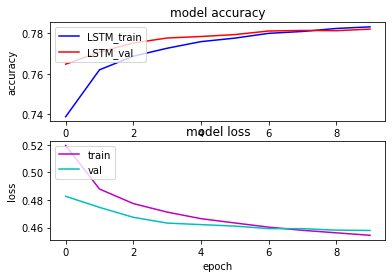

In [35]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

#### **Predict x_test**

In [36]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 66s 2s/step


#### **Confusion Matrix**

In [37]:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

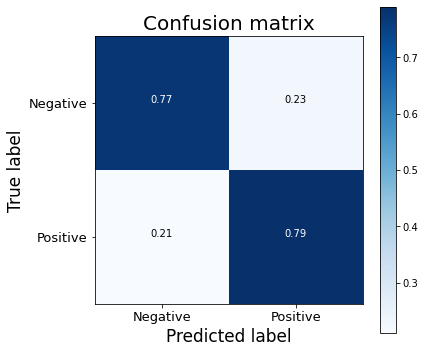

In [38]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

#### **Classification Report**

In [39]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    160542
    Positive       0.78      0.79      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



#### **Recollecting the concepts**
<br>
<br>
<br>

Quality|Actual_Values

* TP – When actual value is TRUE and the predictions are correct (i.e) they are also TRUE
* TN – When actual values are FALSE and the predictions are correct (i.e) they are also FALSE 
* FP – When acutal values is TRUE and the predictions are wrong (i.e) they are FALSE
* FN – When acutal values is FALSE and the predictions are wrong (i.e) they are TRUE

<br>
<br>
<br>
<br>

1. Precision
The precision is the ratio tp / (tp + fp). The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


2. Recall
The recall is the ratio tp / (tp + fn) The recall is intuitively the ability of the classifier to find all the positive samples.


3. F1 Score
The F1 score is the harmonic mean of the precision and recall. The highest possible value of F1 is 1, indicating perfect precision and recall, The lowest possible value is 0, if either the precision or the recall is zero.


4. Support
The support is the number of occurrences of each class in y_true